In [4]:
using NCDatasets
using Plots, ColorSchemes, LaTeXStrings
using DataFrames, CSV
using SparseArrays, LinearAlgebra

In [5]:
#--------------------------------------------------------------------------------------
# Utility Functions
#--------------------------------------------------------------------------------------

function get_endpoints(ds, vars)

    out = Vector{Any}()

    for v in vars
        append!(out, [ds["$v"][:,:,end]])
    end

    return out[1], out[2], out[3], out[4], out[5]

end

function get_nonzero_axes(M)

    Cs = sparse(M)
    (II, JJ, _) = findnz(Cs) 
    
    return II, JJ

end 

function cut_off(ds, n)

    dss = copy(ds)
    co = 10^-6
    for i in range(1, n)
        dss[:, i] .= ifelse.(dss[:, i] .< co, co, dss[:, i])
    end

    return dss

end

function get_zc(ds, H=890)

    dz = 10
    zc = [dz/2:dz:(H-dz/2)]

    return zc
end

get_zc (generic function with 2 methods)

In [6]:
#--------------------------------------------------------------------------------------
# R* Bacteria on Detritus
#--------------------------------------------------------------------------------------
function get_rstar_B(B, Z, ds, nb, nz, season)
    
    mort_b = b_mortality(B, ds, nb)
    grz_b = b_grazing(B, Z, ds, nb, nz)
    loss_b = b_loss(mort_b, grz_b, nb)
    RstarB_ij = Rstar(loss_b, ds, season)

    return RstarB_ij

end

function b_mortality(B, ds, nb)

    mort_b = Any[]
    for i in range(1, nb)
        push!(mort_b, (ds["m_lb"][i] .+ ds["m_qb"][i] .* B[:,i]))
    end

    return mort_b

end

function b_grazing(B, Z, ds, nb, nz)
    #NOTE this all needs to be generalized / scaled !! 
    GrM = ds["GrM"][:]
    grazing = Any[]
    g_max = 1.0
    K_g = 1.0

    #------- for 1N 8P 6Z 13B 5D
    if nb == 13
        np = 8
        prey_POM = GrM[3,9]' .* B[:,1]
        gb_POM = g_max .* prey_POM ./ (prey_POM .+ K_g)
        grz_POM = (gb_POM .* Z[:,3] .* GrM[3,9]' ./ prey_POM) 

        prey = GrM[4,10:end]' .* B[:,2:end]
        for i in range(1, nb-1)
            for j in range(4, nz)
                gb_i = g_max .* prey[:,i] ./ (prey[:,i] .+ K_g)
                grz_i = (gb_i .* Z[:,j] .* GrM[j,i+(np+1)]' ./ prey[:,i]) 
                push!(grazing, grz_i)
            end
        end

        return grazing
    
    end

    #------- for 1N 4P 3Z 7B 4D
    if nb==7
        np=4
        prey_POM = GrM[2,5]' .* B[:,1]
        gb_POM = g_max .* prey_POM ./ (prey_POM .+ K_g)
        grz_POM = (gb_POM .* Z[:,2] .* GrM[2,5]' ./ prey_POM) 
        push!(grazing, grz_POM)

        prey = GrM[3,6:end]' .* B[:,2:end]
        for i in range(1, nb-1)
            gb_i = g_max .* prey[:,i] ./ (prey[:,i] .+ K_g)
            grz_i = (gb_i .* Z[:,3] .* GrM[3,i+(np+1)]' ./ prey[:,i]) 
            push!(grazing, grz_i)
        end
    
        return grazing
    
    else

        #----- for 1N 2P 2Z 2B 2D
        if nz == 2
            K_g = ds["K_g"][2]
            prey = GrM[2,3:end]' .*B[:,1:end]

            for i in range(1, nb)
                gb_i = g_max .* prey[:,i] ./ (prey[:,i] .+ K_g)
                grz_i = (gb_i .* Z[:,2] .* GrM[2,i+2]' ./ prey[:,i])
                push!(grazing, grz_i)
            end

        #----- for 1N 1P 3Z 2B 2D
        elseif nz == 3
            K_g = [ds["K_g"][2], ds["K_g"][3]]
            prey = 1.0 .*B[:,1:2]

            for i in range(1, nb)
                gb_i = g_max .* prey[:,i] ./ (prey[:,i] .+ K_g[i])
                grz_i = (gb_i .* Z[:,i+1] .* 1.0 ./ prey[:,i]) 
                push!(grazing, grz_i)
            end
        else
        end
    end

    return grazing

end

function b_loss(mortality, grazing, nb)

    loss = Any[]
    for i in range(1, nb)
        push!(loss, mortality[i] .+ grazing[i])
    end

    return loss
end

function get_temp_mod(season)
    #fit to SPOT data (approx 20 to 4, approx 16 to 4)
    if season == "Win"
        temp_mod = CSV.read("/home/lee/Dropbox/Development/NPZBD_1D/data/temp_mod/win_temp_mod.csv", DataFrame)
    else
        temp_mod = CSV.read("/home/lee/Dropbox/Development/NPZBD_1D/data/temp_mod/sum_temp_mod.csv", DataFrame)
    end

    return Matrix(temp_mod)
end

function Rstar(loss, ds, season)

    vmax_ij = ds["vmax_ij"][:]
    Km_ij = ds["Km_ij"][:]
    yield = ds["y_ij"][:]
    temp_mod = get_temp_mod(season)

    II, JJ = get_nonzero_axes(ds["CM"][:])
    RS = Any[]
    for j = axes(II, 1)
        push!(RS, Km_ij[II[j],JJ[j]] .* loss[j] ./ (yield[II[j],JJ[j]] .* vmax_ij[II[j],JJ[j]] .* temp_mod .- loss[j]))
    end

    # for i in range(1, length(RS))
    #     RS[i] = check_for_negatives(RS[i])
    # end

    return RS
end

function check_for_negatives(RS)

    for i in eachindex(RS)
        RS[i] = ifelse(RS[i] < 0, NaN, RS[i])
    end

    return RS

end

function extinct(ds, n)

    dss = copy(ds)
    ex = 10^-6
    for i in range(1, n)
        dss[:, i] .= ifelse.(dss[:, i] .== ex, 0.0, dss[:, i])
    end

    return dss

end

extinct (generic function with 1 method)

In [7]:
#--------------------------------------------------------------------------------------
# Plotting
#--------------------------------------------------------------------------------------
function plot_rstar_2B2D(rstar, D, B, ds, season, np)
    # B1 eats D1 (POM)  |  B2 eats D2 (DOM)  
    # zc = get_zc(ds, 500)
    H = 500
    dz = ds["dz"][:]
    zc = [dz/2:dz:(H-dz/2)]
    lg=:bottomright
    tfs=12
    # lbls = [" \textrm{\; B1}_{R*}", " \textrm{\; POM}", " \textrm{\; B1}", " \textrm{\; B2}_{R*}", " \textrm{\; DOM}", " \textrm{\; B2}" ]

    p1 = plot(rstar[1][1:50], -zc, lw=4, lc="red3", ylabel="Depth (m)", label="", xrotation=45, 
    xguidefontsize=12, xlabel=L"R*", border=:box, legend=lg, xscale=:log10, alpha=0.7)
    plot!(D[1:50, 1], -zc, lw=3, lc="blue3", linestyle=:dot, alpha=0.7, label=L" D1")

    p2 = plot(rstar[2][1:50], -zc, lw=4, lc="darkorange", label="",xrotation=45, 
    xguidefontsize=12, xlabel=L"R*", border=:box, legend=lg, xscale=:log10, yformatter=Returns(""), alpha=0.7)
    plot!(D[1:50, 2], -zc, lw=3, lc="black", linestyle=:dot, alpha=0.7, label=" D2")

    p3 = plot(B[1:50, 1], -zc, lw=4, lc="red3", ylabel="", label=" B1",xrotation=45, 
    xguidefontsize=12, xlabel=L"Biomass", border=:box, legend=lg, yformatter=Returns(""), alpha=0.7)
    plot!(B[1:50, 2], -zc, lw=4, lc="darkorange", ylabel="", label=" B2", xrotation=45, 
    xguidefontsize=12, border=:box, legend=lg, alpha=0.7)

    combined = plot(p1, p2, p3,
        fg_legend = :transparent,
        fontfamily="Computer Modern",
        layout = (1,3),
        size=(500,400),
        plot_title=L"R* B_D~ \textrm{(%$season)}",
        plot_xlabel=L"mmol/m^3"
    )

    savefig(combined, "/home/lee/Dropbox/Development/NPZBD_1D/results/plots/rstar/rstarB_$(np)P2B2D_$season.png")

    return combined

end

plot_rstar_2B2D (generic function with 1 method)

<h1> 2B2D - Non-competing </h1>

<h3> 1N 2P 2Z 2B 2D </h3>

* Umax_i = [ 1.091275617275966, 3.091275617275966 ]
* Vmax_i = [ 1.00,  2.391054155817703 ]

* Each B grazes its own D pool  - B1 grazes POM and B2 grazes DOM
* One Z grazes all P, and other grazes all B

In [107]:
winter = NCDataset("/home/lee/Dropbox/Development/NPZBD_1D/results/outfiles/out_100y_20230905_2005.nc")
summer = NCDataset("/home/lee/Dropbox/Development/NPZBD_1D/results/outfiles/out_100y_20230905_2301.nc")
CMd = display(winter["CM"][:])
GrMd = display(winter["GrM"][:])

2×2 Matrix{Float64}:
 1.0  0.0
 0.0  1.0

2×4 Matrix{Float64}:
 1.0  1.0  0.0  0.0
 0.0  0.0  1.0  1.0

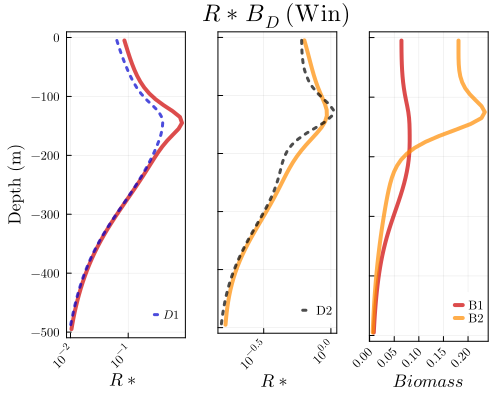

In [110]:
# Get endpoints and set all biomass values below cut-off (10^-6) equal to cut-off
nw, pw, zw, bw, Dw = get_endpoints(winter, ["n", "p", "z", "b", "d"])
ns, ps, zs, bs, Ds = get_endpoints(summer, ["n", "p", "z", "b", "d"])

bww = cut_off(bw, 2)
bss = cut_off(bs, 2)

# Calculate Rstar B
rstarB_ijw = get_rstar_B(bww, zw, winter, 2, 2, "Win")
rstarB_ijs = get_rstar_B(bws, zs, summer, 2, 2, "Sum")

bwe = cut_off(bww, 2)
bse = cut_off(bss, 2)

# Plot
plot_rstar_2B2D(rstarB_ijs, Ds, bse, summer, "Sum", 2)
plot_rstar_2B2D(rstarB_ijw, Dw, bwe, winter, "Win", 2)

<h3> 1N 1P 3Z 2B 2D </h3>

* Umax_i = [  2.091275617275966 ]
* Vmax_i = [ 1.00,  2.391054155817703 ]

* Each B grazes its own D pool  - B1 grazes POM and B2 grazes DOM
* One Z grazes P, one POM consumer, one DOM consumer

In [111]:
winter = NCDataset("/home/lee/Dropbox/Development/NPZBD_1D/results/outfiles/out_100y_20230906_1351.nc")
summer = NCDataset("/home/lee/Dropbox/Development/NPZBD_1D/results/outfiles/out_100y_20230906_1413.nc")
CMd = display(winter["CM"][:])
GrMd = display(winter["GrM"][:])

2×2 Matrix{Float64}:
 1.0  0.0
 0.0  1.0

3×3 Matrix{Float64}:
 1.0  0.0  0.0
 0.0  1.0  0.0
 0.0  0.0  1.0

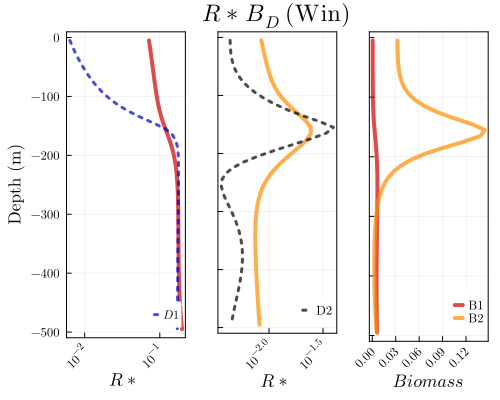

In [112]:
# Get endpoints and set all biomass values below cut-off (10^-6) equal to cut-off
nw, pw, zw, bw, Dw = get_endpoints(winter, ["n", "p", "z", "b", "d"])
ns, ps, zs, bs, Ds = get_endpoints(summer, ["n", "p", "z", "b", "d"])

bww = cut_off(bw, 2)
bws = cut_off(bs, 2)

# Calculate Rstar B
rstarB_ijw = get_rstar_B(bww, zw, winter, 2, 3, "Win")
rstarB_ijs = get_rstar_B(bws, zs, summer, 2, 3, "Sum")

bwe = cut_off(bww, 2)
bse = cut_off(bss, 2)

# Plot
plot_rstar_2B2D(rstarB_ijs, Ds, bse, summer, "Sum", 1)
plot_rstar_2B2D(rstarB_ijw, Dw, bwe, winter, "Win", 1)

<h2> For competing B - 7B4D </h2>

In [62]:
using Plots
function plot_rstar_7B4D(rstar_w, rstar_s, Dw, Ds, bw, bs, ds, N)
    # B1 eats D1 (POM)  |  B2 & B7 eat D2  |  B3 & B6 eat D3  |  B4 & B5 eat D4
    # H = ds["H"][:]
    H = 500
    dz = 10
    zc = [dz/2:dz:(H-dz/2)]

    # yl=(-400.0, 0)
    lg=:bottomright
    tfs=18

    p1 = plot(rstar_w[1][1:50], -zc, lw=4, lc="red3", label=L" B1", ylabel="Depth (m)", 
    xrotation=45, xguidefontsize=12, xlabel=L"R*", border=:box, legend=lg, xscale=:log10)
    plot!(Dw[1:50, 1], -zc, lw=3, lc="blue3", linestyle=:dot,label=L" D1", alpha=0.4)

    p2 = plot(rstar_w[3][1:50], -zc, lw=4, lc="darkorange", label="", 
    xrotation=45, xguidefontsize=12, xlabel=L"R*", border=:box, legend=lg, xscale=:log10, yformatter=Returns(""))
    plot!(rstar_w[6][1:50], -zc, lw=4, lc="magenta2",  label="")
    plot!(Dw[1:50, 3], -zc, lw=4, lc="black", linestyle=:dot, alpha=0.6, label=L" D3")

    p3 = plot(bw[1:50, 3], -zc, lw=4, lc="darkorange", label=L" B3", 
    xrotation=45, xguidefontsize=12, xlabel=L"Biomass", border=:box, legend=lg, yformatter=Returns(""), xlims=(-0.01, 0.2))
    plot!(bw[1:50, 6], -zc, lw=4, lc="magenta2",  label=L" B6", alpha=0.8)

    p4 = plot(rstar_w[4][1:50], -zc, lw=4, lc="gold4", label="", 
    xrotation=45, xguidefontsize=12, xlabel=L"R*", border=:box, legend=lg, xscale=:log10, yformatter=Returns(""))
    plot!(rstar_w[5][1:50], -zc, lw=4, lc="lightcyan4", label="")
    plot!(Dw[1:50, 4], -zc, lw=4, lc="purple", linestyle=:dot, alpha=0.6, label=L" D4")

    p5 = plot(bw[1:50, 4], -zc, lw=4, lc="gold4", label=L" B4", 
    xrotation=45, xguidefontsize=12, xlabel=L"Biomass", border=:box, legend=lg, yformatter=Returns(""), xlims=(-0.01, 0.2))
    plot!(bw[1:50, 5], -zc, lw=4, lc="lightcyan4", label=L" B5", alpha=0.8)

    #--------------------------------------------------------------------------------------------

    p6 = plot(rstar_s[1][1:50], -zc, lw=4, lc="red3", label=L" B1", ylabel="Depth (m)", 
    xrotation=45, xguidefontsize=12, xlabel=L"R*", border=:box, legend=lg, xscale=:log10)
    plot!(Ds[1:50, 1], -zc, lw=3, lc="blue3", linestyle=:dot,label=L" D1", alpha=0.4)

    p7 = plot(rstar_s[3][1:50], -zc, lw=4, lc="darkorange", label="", 
    xrotation=45, xguidefontsize=12, xlabel=L"R*", border=:box, legend=lg, xscale=:log10, yformatter=Returns(""))
    plot!(rstar_s[6][1:50], -zc, lw=4, lc="magenta2", label="")
    plot!(Ds[1:50, 3], -zc, lw=4, lc="black", linestyle=:dot, alpha=0.6, label=L" D3")

    p8 = plot(bs[1:50, 3], -zc, lw=4, lc="darkorange", label=L" B3", 
    xrotation=45, xguidefontsize=12, xlabel=L"Biomass", border=:box, legend=lg, yformatter=Returns(""), xlims=(-0.01, 0.2))
    plot!(bs[1:50, 6], -zc, lw=4, lc="magenta2", label=L" B6", alpha=0.8)

    p9 = plot(rstar_s[4][1:50], -zc, lw=4, lc="gold4", label="", 
    xrotation=45, xguidefontsize=12, xlabel=L"R*", border=:box, legend=lg, xscale=:log10, yformatter=Returns(""))
    plot!(rstar_s[5][1:50], -zc, lw=4, lc="lightcyan4", label="")
    plot!(Ds[1:50, 4], -zc, lw=4, lc="purple", linestyle=:dot, alpha=0.6, label=L" D4")

    p10 = plot(bs[1:50, 4], -zc, lw=4, lc="gold4", label=L" B4", 
    xrotation=45, xguidefontsize=12, xlabel=L"Biomass", border=:box, legend=lg, yformatter=Returns(""), xlims=(-0.01, 0.2))
    plot!(bs[1:50, 5], -zc, lw=4, lc="lightcyan4", label=L" B5", alpha=0.8)
    
    
    combined = plot(p1, p2, p3, p4, p5, p6, p7, p8, p9, p10,
        fg_legend = :transparent,
        layout = (2,5),
        size=(900,700),
        # xlabel = "R*",
        # plot_title="Winter", 
        # titlefontsize=tfs, titlelocation=:center, 
    )

    # savefig(combined,"/home/lee/Dropbox/Development/NPZBD_1D/results/plots/rstar/rstar_7B4D.png")
    
    return combined

end

plot_rstar_7B4D (generic function with 1 method)

In [57]:
winter = NCDataset("/home/lee/Dropbox/Development/NPZBD_1D/results/outfiles/endpoints/Wi100y_230827_13:45_4P3Z7B4D_ep.nc")
summer = NCDataset("/home/lee/Dropbox/Development/NPZBD_1D/results/outfiles/endpoints/Su100y_230827_17:10_4P3Z7B4D_ep.nc")
CMd = display(winter["CM"][:])
GrMd = display(winter["GrM"][:])

4×7 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  1.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  1.0  1.0  0.0  0.0

3×11 Matrix{Float64}:
 1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0

In [ ]:
# Get endpoints and set all biomass values below cut-off (10^-6) equal to cut-off
Nw, Pw, Zw, Bw, Dw = get_endpoints(winter, ["n", "p", "z", "b", "d"])
Ns, Ps, Zs, Bs, Ds = get_endpoints(summer, ["n", "p", "z", "b", "d"])

Bww = cut_off(Bw, 7)
Bss = cut_off(Bs, 7)

# Calculate Rstar B
rstarB_ijw = get_rstar_B(Bww, Zw, winter, 7, 3, "Win")
rstarB_ijs = get_rstar_B(Bss, Zs, summer, 7, 3, "Sum")

Bwe = extinct(Bww, 7)
Bse = extinct(Bss, 7)

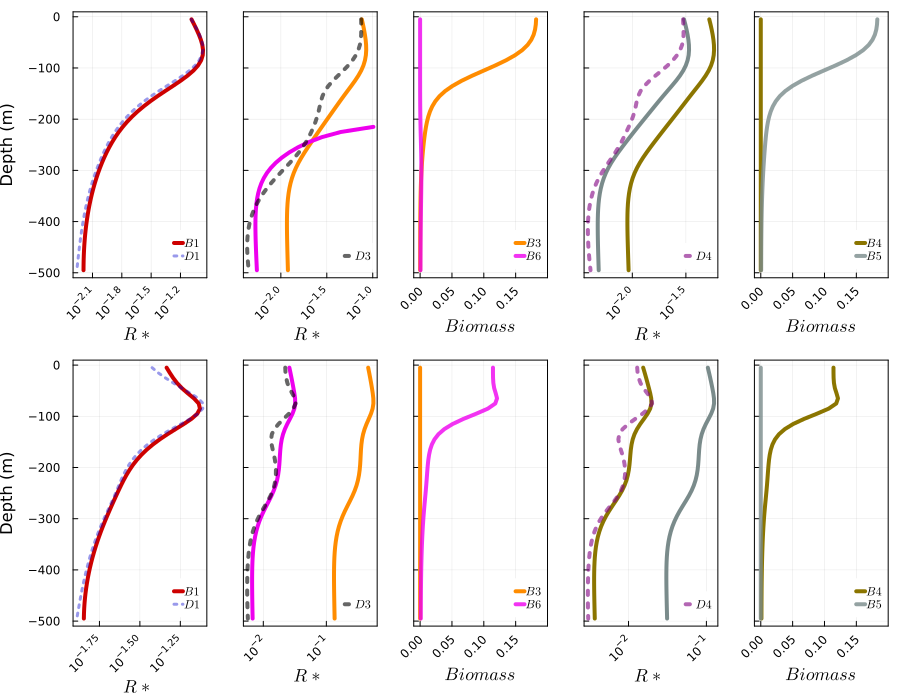

In [63]:
# Plot plot_rstar_7B4D(rstar_w, rstar_s, Dw, Ds, bw, bs, ds, N)
plot_rstar_7B4D(rstarB_ijw, rstarB_ijs, Dw, Ds, Bwe, Bse, winter, 7)

NOTE

* In winter, B3 and B4 'win' and have very similar overall biomass
* B3 and B4 also have very similar relationship to D3 and D4, respectively

* In summer, B6 and B4 


<h1> For competing B - 13B 5D </h1>

In [7]:
winter = NCDataset("/home/lee/Dropbox/Development/NPZBD_1D/results/outfiles/Wi100y_230915_22:19_8P6Z13B5D.nc")
summer = NCDataset("/home/lee/Dropbox/Development/NPZBD_1D/results/outfiles/Su100y_230916_11:25_8P6Z13B5D.nc")
CMd = display(winter["CM"][:])
GrMd = display(winter["GrM"][:])

5×13 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0

6×21 Matrix{Float64}:
 1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  1.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  1.0  0.0  0.0  1.0  0.0  1.0

In [16]:
# Get endpoints and set all biomass values below cut-off (10^-6) equal to cut-off
Nw, Pw, Zw, Bw, Dw = get_endpoints(winter, ["n", "p", "z", "b", "d"])
Ns, Ps, Zs, Bs, Ds = get_endpoints(summer, ["n", "p", "z", "b", "d"])

Bww = cut_off(Bw, 13)
Bss = cut_off(Bs, 13)

# Calculate Rstar B
rstarB_ijw = get_rstar_B(Bww, Zw, winter, 13, 6, "Win")
rstarB_ijs = get_rstar_B(Bss, Zs, summer, 13, 6, "Sum")

Bwe = extinct(Bww, 13)
Bse = extinct(Bss, 13)

89×13 Matrix{Float64}:
 0.0631937   0.0  0.0  0.0568375   …  0.0  0.0742796    0.0410167   0.0
 0.0633398   0.0  0.0  0.05675        0.0  0.0741583    0.0409478   0.0
 0.0637548   0.0  0.0  0.05645        0.0  0.0737477    0.0407109   0.0
 0.0645053   0.0  0.0  0.0556817      0.0  0.0727156    0.0401046   0.0
 0.065395    0.0  0.0  0.0539954      0.0  0.0704878    0.038776    0.0
 0.0657407   0.0  0.0  0.0508091   …  0.0  0.0663179    0.0362672   0.0
 0.0645207   0.0  0.0  0.0457638      0.0  0.0597306    0.0322902   0.0
 0.0611191   0.0  0.0  0.0391937      0.0  0.0511443    0.0271124   0.0
 0.0558996   0.0  0.0  0.0320825      0.0  0.0418391    0.0215529   0.0
 0.0498355   0.0  0.0  0.0254374      0.0  0.0331422    0.016471    0.0
 ⋮                                 ⋱       ⋮                        
 0.00852349  0.0  0.0  2.7954e-5   …  0.0  0.000350426  0.00120367  0.0
 0.00873919  0.0  0.0  2.79732e-5     0.0  0.000350961  0.00120629  0.0
 0.00893492  0.0  0.0  2.79885e-5     0.0  0

In [18]:
Bwe[:,3]


89-element Vector{Float64}:
 0.028530027588891994
 0.028502401124194866
 0.028430626819077525
 0.02829097062911559
 0.02805020092211825
 0.027663488496541298
 0.027073743425170254
 0.02621476830541822
 0.02502152552211064
 0.023449270980776222
 ⋮
 0.0008907665216855266
 0.0008908337542307047
 0.0008908756270819704
 0.0008908991615775503
 0.000890910087836211
 0.0008909130189276001
 0.0008909116103458
 0.0008909087041388295
 0.0008909064577011231

In [69]:
function plot_rstar_13B5D(rstar_w, rstar_s, Dw, Ds, bw, bs, ds, N)
    # B1 eats D1 (POM)  |  B2, B6, B10 eat D2  |  B3, B7, B11 eat D3  |  B4, B7, B12 eat D4 | B5, B8, B13 eat D5
    # H = ds["H"][:]
    H = 500
    dz = ds["dz"][:]
    zc = [dz/2:dz:(H-dz/2)]

    # yl=(-400.0, 0)
    lg=:bottomright
    tl=:right
    tfs=14
    # xl=(-0.01, 0.08)
    ab=0.8

    p1 = plot(rstar_w[1][1:50], -zc, lw=4, lc="red3", label=L" B1", ylabel="Depth (m)", 
    xrotation=45, xguidefontsize=12, xlabel=L"R*", border=:box, legend=lg, title="D1", title_loc=tl, titlefontsize=tfs)
    plot!(Dw[1:50, 1], -zc, lw=3, lc="blue3", linestyle=:dot,label=L" D1", alpha=0.4)

    p2 = plot(rstar_w[2][1:50], -zc, lw=4, lc="darkorange", label="", xrotation=45, xguidefontsize=12, xlabel=L"R*", 
    border=:box, legend=lg, title="D2", title_loc=tl, yformatter=Returns(""), titlefontsize=tfs)
    plot!(rstar_w[6][1:50], -zc, lw=4, lc="magenta2",  label="")
    plot!(rstar_w[10][1:50], -zc, lw=4, lc="purple",  label="")
    plot!(Dw[1:50, 2], -zc, lw=4, lc="black", linestyle=:dot, alpha=0.6, label=L" D2")

    p3 = plot(bw[1:50, 2], -zc, lw=4, lc="darkorange", label=L" B2", xrotation=45, xguidefontsize=12, xlabel=L"Biomass", 
    border=:box, legend=lg, yformatter=Returns(""), alpha=ab)
    plot!(bw[1:50, 6], -zc, lw=4, lc="magenta2",  label=L" B6", alpha=ab)
    plot!(bw[1:50, 10], -zc, lw=4, lc="purple",  label=L" B10", alpha=ab)

    p4 = plot(rstar_w[3][1:50], -zc, lw=4, lc="gold4", label="", xrotation=45, xguidefontsize=12, xlabel=L"R*", 
    border=:box, legend=lg, title="D3", title_loc=tl, yformatter=Returns(""), titlefontsize=tfs)
    plot!(rstar_w[7][1:50], -zc, lw=4, lc="lightcyan4", label="")
    plot!(rstar_w[11][1:50], -zc, lw=4, lc="darkgrey", label="")
    plot!(Dw[1:50, 3], -zc, lw=4, lc="olive", linestyle=:dot, alpha=0.6, label=L" D3")

    p5 = plot(bw[1:50, 3], -zc, lw=4, lc="gold4", label=L" B3", xrotation=45, xguidefontsize=12, xlabel=L"Biomass", 
    border=:box, legend=lg, yformatter=Returns(""), alpha=ab)
    plot!(bw[1:50, 7], -zc, lw=4, lc="lightcyan4", label=L" B7", alpha=ab)
    plot!(bw[1:50, 11], -zc, lw=4, lc="darkgrey", label=L" B11", alpha=ab)

    p6 = plot(rstar_w[4][1:50], -zc, lw=4, lc="coral4", label="", xrotation=45, xguidefontsize=12, xlabel=L"R*", 
    border=:box, legend=lg, title="D4", title_loc=tl, yformatter=Returns(""), titlefontsize=tfs)
    plot!(rstar_w[8][1:50], -zc, lw=4, lc="seagreen4", label="")
    plot!(rstar_w[12][1:50], -zc, lw=4, lc="azure4", label="")
    plot!(Dw[1:50, 4], -zc, lw=4, lc="navy", linestyle=:dot, alpha=0.6, label=L" D4")

    p7 = plot(bw[1:50, 4], -zc, lw=4, lc="coral4", label=L" B4", xrotation=45, xguidefontsize=12, xlabel=L"Biomass", 
    border=:box, legend=lg, yformatter=Returns(""), alpha=ab)
    plot!(bw[1:50, 8], -zc, lw=4, lc="seagreen4", label=L" B8", alpha=ab)
    plot!(bw[1:50, 12], -zc, lw=4, lc="azure4", label=L" B12", alpha=ab)

    p8 = plot(rstar_w[5][1:50], -zc, lw=4, lc="orchid2", label="", xrotation=45, xguidefontsize=12, xlabel=L"R*", 
    border=:box, legend=lg, title="D5", title_loc=tl, yformatter=Returns(""), titlefontsize=tfs)
    plot!(rstar_w[9][1:50], -zc, lw=4, lc="darkkhaki", label="")
    plot!(rstar_w[13][1:50], -zc, lw=4, lc="turquoise1", label="")
    plot!(Dw[1:50, 5], -zc, lw=4, lc="brown4", linestyle=:dot, alpha=0.6, label=L" D5")

    p9 = plot(bw[1:50, 5], -zc, lw=4, lc="orchid2", label=L" B5", xrotation=45, xguidefontsize=12, xlabel=L"Biomass", 
    border=:box, legend=lg, yformatter=Returns(""), alpha=ab)
    plot!(bw[1:50, 9], -zc, lw=4, lc="darkkhaki", label=L" B9", alpha=ab)
    plot!(bw[1:50, 13], -zc, lw=4, lc="turquoise1", label=L" B13", alpha=ab)

    #--------------------------------------------------------------------------------------------

    p10 = plot(rstar_s[1][1:50], -zc, lw=4, lc="red3", label=L" B1", ylabel="Depth (m)", 
    xrotation=45, xguidefontsize=12, xlabel=L"R*", border=:box, legend=lg, title="D1", title_loc=tl, titlefontsize=tfs)
    plot!(Ds[1:50, 1], -zc, lw=3, lc="blue3", linestyle=:dot,label=L" D1", alpha=0.4)

    p11 = plot(rstar_s[2][1:50], -zc, lw=4, lc="darkorange", label="", xrotation=45, xguidefontsize=12, xlabel=L"R*", 
    border=:box, legend=lg, title="D2", title_loc=tl, yformatter=Returns(""), titlefontsize=tfs)
    plot!(rstar_s[6][1:50], -zc, lw=4, lc="magenta2",  label="")
    plot!(rstar_s[10][1:50], -zc, lw=4, lc="purple",  label="")
    plot!(Ds[1:50, 2], -zc, lw=4, lc="black", linestyle=:dot, alpha=0.6, label=L" D2")

    p12 = plot(bs[1:50, 2], -zc, lw=4, lc="darkorange", label=L" B2", xrotation=45, xguidefontsize=12, xlabel=L"Biomass", 
    border=:box, legend=lg, yformatter=Returns(""), alpha=ab)
    plot!(bs[1:50, 6], -zc, lw=4, lc="magenta2",  label=L" B6", alpha=ab)
    plot!(bs[1:50, 10], -zc, lw=4, lc="purple",  label=L" B10", alpha=ab)

    p13 = plot(rstar_s[3][1:50], -zc, lw=4, lc="gold4", label="", xrotation=45, xguidefontsize=12, xlabel=L"R*", 
    border=:box, legend=lg, title="D3", title_loc=tl, yformatter=Returns(""), titlefontsize=tfs)
    plot!(rstar_s[7][1:50], -zc, lw=4, lc="lightcyan4", label="")
    plot!(rstar_s[11][1:50], -zc, lw=4, lc="darkgrey", label="")
    plot!(Ds[1:50, 3], -zc, lw=4, lc="olive", linestyle=:dot, alpha=0.6, label=L" D3")

    p14 = plot(bs[1:50, 3], -zc, lw=4, lc="gold4", label=L" B3", xrotation=45, xguidefontsize=12, xlabel=L"Biomass", 
    border=:box, legend=lg, yformatter=Returns(""), alpha=ab)
    plot!(bs[1:50, 7], -zc, lw=4, lc="lightcyan4", label=L" B7", alpha=ab)
    plot!(bs[1:50, 11], -zc, lw=4, lc="darkgrey", label=L" B11", alpha=ab)

    p15 = plot(rstar_s[4][1:50], -zc, lw=4, lc="coral4", label="", xrotation=45, xguidefontsize=12, xlabel=L"R*", 
    border=:box, legend=lg, title="D4", title_loc=tl, yformatter=Returns(""), titlefontsize=tfs)
    plot!(rstar_s[8][1:50], -zc, lw=4, lc="seagreen4", label="")
    plot!(rstar_s[12][1:50], -zc, lw=4, lc="azure4", label="")
    plot!(Ds[1:50, 4], -zc, lw=4, lc="navy", linestyle=:dot, alpha=0.6, label=L" D4")

    p16 = plot(bs[1:50, 4], -zc, lw=4, lc="coral4", label=L" B4", xrotation=45, xguidefontsize=12, xlabel=L"Biomass", 
    border=:box, legend=lg, yformatter=Returns(""), alpha=ab)
    plot!(bs[1:50, 8], -zc, lw=4, lc="seagreen4", label=L" B8", alpha=ab)
    plot!(bs[1:50, 12], -zc, lw=4, lc="azure4", label=L" B12", alpha=ab)

    p17 = plot(rstar_s[5][1:50], -zc, lw=4, lc="orchid2", label="", xrotation=45, xguidefontsize=12, xlabel=L"R*", 
    border=:box, legend=lg, title="D5", title_loc=tl, yformatter=Returns(""), titlefontsize=tfs)
    plot!(rstar_s[9][1:50], -zc, lw=4, lc="darkkhaki", label="")
    plot!(rstar_s[13][1:50], -zc, lw=4, lc="turquoise1", label="")
    plot!(Ds[1:50, 5], -zc, lw=4, lc="brown4", linestyle=:dot, alpha=0.6, label=L" D5")

    p18 = plot(bs[1:50, 5], -zc, lw=4, lc="orchid2", label=L" B5", xrotation=45, xguidefontsize=12, xlabel=L"Biomass", 
    border=:box, legend=lg, yformatter=Returns(""), alpha=ab)
    plot!(bs[1:50, 9], -zc, lw=4, lc="darkkhaki", label=L" B9", alpha=ab)
    plot!(bs[1:50, 13], -zc, lw=4, lc="turquoise1", label=L" B13", alpha=ab)
    
    winter = plot(p1,p2,p3,p4,p5,p6,p7,p8,p9, 
    fg_legend = :transparent,
    layout = (1,9),
    size=(1300,450),
    # xlabel = "R*",
    # plot_title="Winter", 
    # plot_titlefontsize = 20,
    # titlefontsize=tfs, titlelocation=:center, 
    )

    summer = plot(p10,p11,p12,p13,p14,p15,p16,p17, p18,
    fg_legend = :transparent,
    layout = (1,9),
    size=(1300,450),
    # xlabel = "R*",
    # plot_title="Summer", 
    # plot_titlefontsize = 20,
    # titlefontsize=tfs, titlelocation=:center, 
    )
    
    combined = plot(winter, summer, 
        fg_legend = :transparent,
        layout = (2,1),
        size=(1300,900),
        # xlabel = "R*",
        # plot_title="Winter", 
        # titlefontsize=tfs, titlelocation=:center, 
    )

    savefig(combined,"/home/lee/Dropbox/Development/NPZBD_1D/results/plots/rstar/rstar_13B5D.png")
    
    return combined

end

plot_rstar_13B5D (generic function with 1 method)

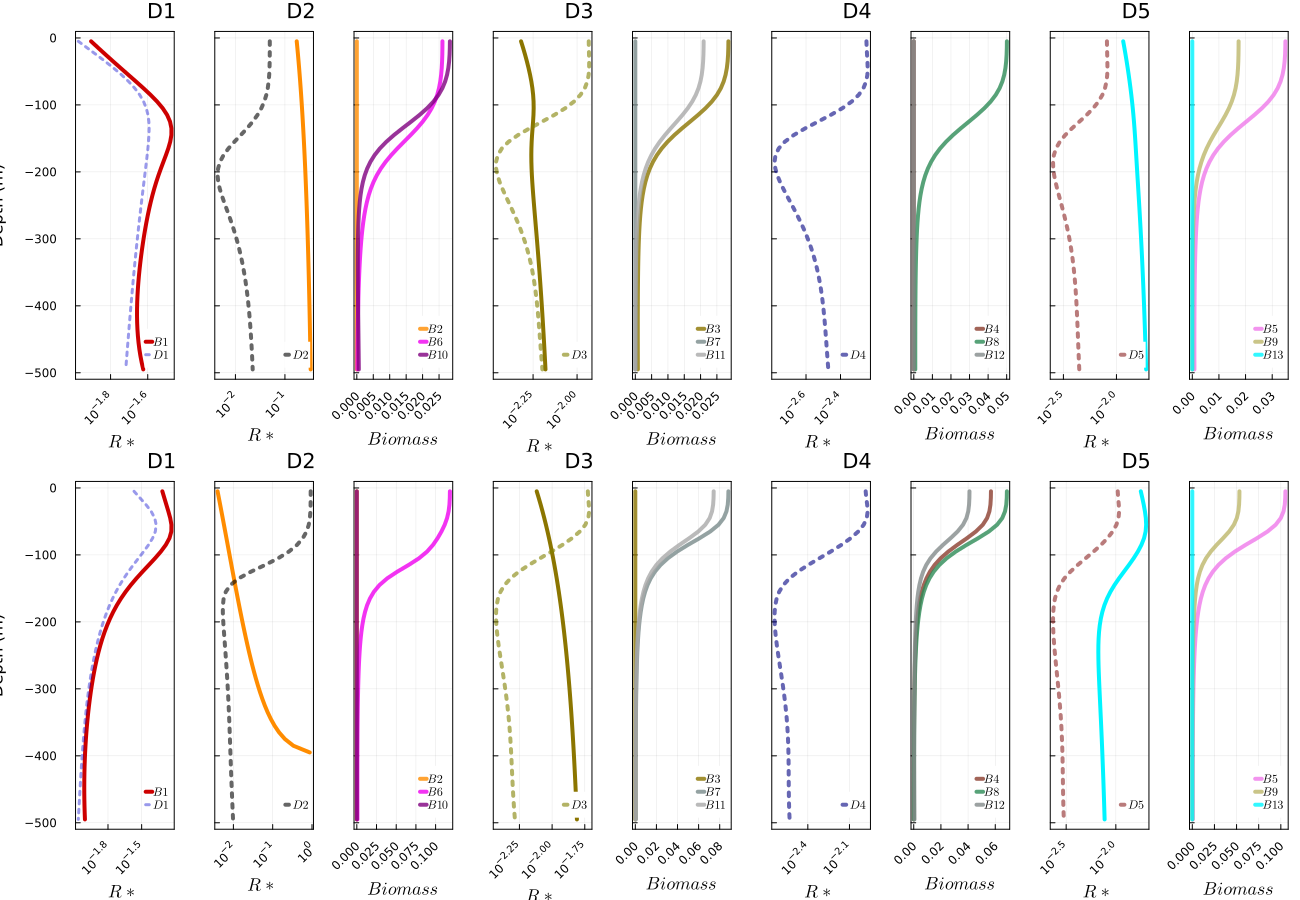

In [50]:
plot_rstar_13B5D(rstarB_ijw, rstarB_ijs, Dw, Ds, Bwe, Bse, winter, 13)